### Prerequisites

In [ ]:
%%capture
! pip install levenshtein
! pip install datasets
! pip install evaluate
! pip install transformers[torch]
! pip install wget
! pip install chromadb

import pandas as pd
from Levenshtein import distance
import re
import wget
import zipfile
import chromadb
from pathlib import Path
from huggingface_hub import notebook_login
from torch import nn

In [ ]:
notebook_login()

## Скачивание DBPedia онтологии и инфопоиск по ней

In [ ]:
!wget https://raw.githubusercontent.com/PhilBurub/NLPcourse_HSE/main/database.py

--2024-03-24 18:05:35--  https://raw.githubusercontent.com/PhilBurub/NLPcourse_HSE/main/database.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 821 [text/plain]
Saving to: ‘database.py’

database.py         100%[===================>]     821  --.-KB/s    in 0s      

2024-03-24 18:05:36 (38.4 MB/s) - ‘database.py’ saved [821/821]



In [ ]:
from database import VectDB

In [ ]:
db = VectDB()

In [ ]:
db.query('Question: Who is the tallest person in Hollywood?\nAnswer: Lana del Rey', top_n=3)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:19<00:00, 4.35MiB/s]


{'ids': [['527', '543', '607']],
 'distances': [[1.483119010925293, 1.4964747428894043, 1.4980891942977905]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['PlayboyPlaymate is a subclass of Person',
   'Woman is a subclass of Person',
   'Wrestler is a subclass of Athlete']],
 'uris': None,
 'data': None}

In [ ]:
db.query('Question: Who is the tallest person in Hollywood?\nAnswer: Ryan Gosling', top_n=3)

{'ids': [['546', '521', '556']],
 'distances': [[1.225118637084961, 1.4215075969696045, 1.484468936920166]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['Actor is a subclass of Artist',
   'MovieDirector is a subclass of Person',
   'AdultActor is a subclass of Actor']],
 'uris': None,
 'data': None}

## Загрузка данных


Файлы `train_dataset_top5.csv ` и `test_dataset_top5.csv ` с 5 кандидатами GPT-3.5 на вопросы Mintaka (мы взяли 1000 примеров из трейна и 250 из теста, так как при датасет для обучения будет в 5 раз больше за счет нескольких вариантов ответа)



In [ ]:
train_top5 = pd.read_csv('train_dataset_top5.csv')
test_top5 = pd.read_csv('test_dataset_top5.csv')

In [ ]:
train_top5

,id,question,answerText,top1,top2,top3,top4,top5
0,a9011ddf,What is the seventh tallest mountain in North ...,Mount Lucania,Mount Hubbard,Mount Bear,Mount Alverstone,Mount Kennedy,University Peak
1,2723bb1b,Which actor was the star of Titanic and was bo...,Leonardo DiCaprio,Leonardo DiCaprio,Kate Winslet,James Cameron,Rose DeWitt Bukater,Jack Dawson
2,88349c89,Which actor starred in Vanilla Sky and was mar...,Tom Cruise,Tom Cruise,Tom Cruise,Tom Cruise,Tom Cruise,Tom Cruise
3,982450cf,Who is the youngest current US governor?,Ron DeSantis,Ron DeSantis,Jared Polis,Gretchen Whitmer,Spencer Cox,Kay Ivey
4,fe541d01,Which US president has had the most votes?,Joe Biden,Barack Obama,Joe Biden,Donald Trump,George W. Bush,Bill Clinton
...,...,...,...,...,...,...,...,...
995,64f0c72c,What is the first British Rolling Stones' stud...,The Rolling Stones,The Rolling Stones,England's Newest Hit Makers,The Rolling Stones No. 2,Out of Our Heads,Aftermath
996,080beeb3,What is the second British Rolling Stones' stu...,The Rolling Stones No. 2,"""Out of Our Heads""","""Aftermath""","""Between the Buttons""","""Their Satanic Majesties Request""","""Beggars Banquet"""
997,e763972e,What is the third British Rolling Stones' stud...,Out of Our Heads,Out of Our Heads,Aftermath,Between the Buttons,Their Satanic Majesties Request,Beggars Banquet
998,9f7c5dd9,What was the Foo Fighters' first album called?,Foo Fighters,Foo Fighters,Foo Fighters,Foo Fighters,Foo Fighters,Foo Fighters


In [ ]:
train_top1 = pd.read_csv('train_dataset_top1.csv')
train_top1

,id,question,answerText,top1
0,a9011ddf,What is the seventh tallest mountain in North ...,Mount Lucania,Mount Logan
1,2723bb1b,Which actor was the star of Titanic and was bo...,Leonardo DiCaprio,Leonardo DiCaprio
2,88349c89,Which actor starred in Vanilla Sky and was mar...,Tom Cruise,Tom Cruise
3,982450cf,Who is the youngest current US governor?,Ron DeSantis,Madison Cawthorn
4,fe541d01,Which US president has had the most votes?,Joe Biden,Joe Biden
...,...,...,...,...
995,64f0c72c,What is the first British Rolling Stones' stud...,The Rolling Stones,The Rolling Stones
996,080beeb3,What is the second British Rolling Stones' stu...,The Rolling Stones No. 2,"""Let It Bleed"""
997,e763972e,What is the third British Rolling Stones' stud...,Out of Our Heads,Out of Our Heads
998,9f7c5dd9,What was the Foo Fighters' first album called?,Foo Fighters,Foo Fighters


In [ ]:
def generate_string_for_classify(question, answer_candidate, sep_token="[SEP]"):

    string_for_classify = ""
    question_and_answer = 'Question: ' + question + '\nAnswer: ' + answer_candidate
    ontology_information = db.query(question_and_answer, top_n=1)['documents'][0][0]
    string_for_classify += question + sep_token + answer_candidate + sep_token + ontology_information

    return string_for_classify

def are_similar(true_answer, answer_candidate):

  film_year_reg = re.compile('\(\d{4}\)')

  if answer_candidate[0] == '"' and answer_candidate[-1] == '"':
    answer_candidate = answer_candidate[1:-1]
  if len(re.findall(film_year_reg, answer_candidate)) ==  1 and len(re.findall(film_year_reg, true_answer)) == 0:
    answer_candidate = re.sub(film_year_reg, '', answer_candidate)

  if distance(true_answer, answer_candidate) <= 2:
    return 1
  else:
    return 0

In [ ]:
train_top5.loc[3]

id                                            982450cf
question      Who is the youngest current US governor?
answerText                                Ron DeSantis
top1                                      Ron DeSantis
top2                                       Jared Polis
top3                                  Gretchen Whitmer
top4                                       Spencer Cox
top5                                          Kay Ivey
Name: 3, dtype: object

Нужна загруженная db, сбор датасета занимает 10 минут (трейн + тест)

In [ ]:
from collections import defaultdict

train_dataset = defaultdict(list)

candidate_list = ['top1', 'top2', 'top3', 'top4', 'top5']

for idx in range(train_top5.index.size):
  candidates = [train_top5.iloc[idx]['top1'], train_top5.iloc[idx]['top2'], train_top5.iloc[idx]['top3'], train_top5.iloc[idx]['top4'], train_top5.iloc[idx]['top5']]
  candidates = list(set(candidates))
  candidates = [x for x in candidates if type(x) == str]
  for candidate in candidates:
    label = are_similar(train_top5.iloc[idx]['answerText'], candidate)
    string_for_classify = generate_string_for_classify(train_top5.iloc[idx]['question'], candidate)

    train_dataset['label'].append(label)
    train_dataset['string_example'].append(string_for_classify)

In [ ]:
print(train_dataset['label'].count(0))
print(train_dataset['label'].count(1))

3755
794


In [ ]:
test_dataset = defaultdict(list)

candidate_list = ['top1', 'top2', 'top3', 'top4', 'top5']

for idx in range(test_top5.index.size):
  candidates = [test_top5.iloc[idx]['top1'], test_top5.iloc[idx]['top2'], test_top5.iloc[idx]['top3'], test_top5.iloc[idx]['top4'], test_top5.iloc[idx]['top5']]
  candidates = list(set(candidates))
  candidates = [x for x in candidates if type(x) == str]
  for candidate in candidates:
    label = are_similar(test_top5.iloc[idx]['answerText'], candidate)
    string_for_classify = generate_string_for_classify(test_top5.iloc[idx]['question'], candidate)

    test_dataset['label'].append(label)
    test_dataset['string_example'].append(string_for_classify)

In [ ]:
print(test_dataset['label'].count(0))
print(test_dataset['label'].count(1))

920
193


## Пайплайн:

1. Обращаемся к гигачату с вопросом, получаем топ-икс ответов
2. Для каждого ответа ищем информацию по онтологии
3. Подаём в модель sequence ranker триплеты *вопрос-ответ-онтология*
4. Берём топ-1 по рангу триплет в качестве ответа
5. (Замеряем качество)

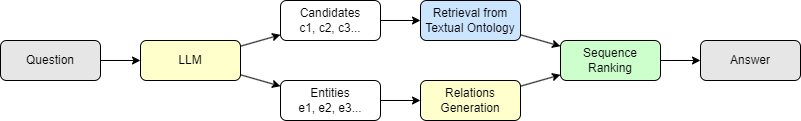

## Обучение sequence ranker для DBPedia онтологии

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset

In [ ]:
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)

train_dataset, test_dataset

(Dataset({
     features: ['label', 'string_example'],
     num_rows: 4549
 }),
 Dataset({
     features: ['label', 'string_example'],
     num_rows: 1113
 }))

## BERT classifier

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-large-cased")
model = BertForSequenceClassification.from_pretrained("bert-large-cased", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_fn(examples):
    return tokenizer(examples['string_example'], padding="max_length", truncation=True)


train_dataset = train_dataset.map(tokenize_fn, batched=True).shuffle()
test_dataset = test_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/4549 [00:00<?, ? examples/s]

Map:   0%|          | 0/1113 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import evaluate

metric = evaluate.combine(['f1', 'precision', 'recall', 'accuracy'])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from torch import nn
from transformers import Trainer


target = np.array(train_dataset['label']).astype(int)

class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1. / class_sample_count

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight).float()).to(logits.device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
weight

array([0.00026631, 0.00125945])

### bert-large-cased: попытка 1

In [ ]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_first_step=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    # load_best_model_at_end=True,
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.476700,0.912060,0.000000,0.000000,0.000000,0.826595
1,0.461600,0.878091,0.000000,0.000000,0.000000,0.826595
2,0.451500,0.883618,0.221311,0.529412,0.139896,0.829290
3,0.422100,0.893046,0.236220,0.491803,0.155440,0.825696
4,0.380800,0.786225,0.356546,0.385542,0.331606,0.792453
5,0.315000,0.903165,0.310345,0.463918,0.233161,0.820305


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


На обучение одной эпохи уходит порядка 20 минут.

На пятой эпохе происходит переобучение, и бесплатного коллаба хватает только на 6 эпох, поэтому прогоним теперь 4 эпохи с теми же гиперпараметрами и сохраним модель.

### bert-large-cased: попытка 2

In [ ]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=4,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_first_step=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    # load_best_model_at_end=True,
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.477500,0.816974,0.000000,0.000000,0.000000,0.826595
1,0.457700,0.934509,0.068293,0.583333,0.036269,0.828392
2,0.412000,0.806044,0.344828,0.436508,0.284974,0.812219
3,0.353000,0.882722,0.365169,0.398773,0.336788,0.796945


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1136, training_loss=0.4256239025525644, metrics={'train_runtime': 6487.2509, 'train_samples_per_second': 2.805, 'train_steps_per_second': 0.175, 'total_flos': 1.6938784459849728e+16, 'train_loss': 0.4256239025525644, 'epoch': 4.0})

In [ ]:
train_dataset.save_to_disk('train_dataset_dbpedia')
test_dataset.save_to_disk('test_dataset_dbpedia')

Saving the dataset (0/1 shards):   0%|          | 0/4549 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1113 [00:00<?, ? examples/s]

### bert-base-cased: попытка 1

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_fn(examples):
    return tokenizer(examples['string_example'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_fn, batched=True).shuffle()
test_dataset = test_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/4549 [00:00<?, ? examples/s]

Map:   0%|          | 0/1113 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='test_trainer',
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    metric_for_best_model='f1',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_first_step=True,
    load_best_model_at_end=True
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.696700,0.679573,0.275618,0.433333,0.202073,0.815813
2,0.684800,0.659800,0.351967,0.293103,0.440415,0.718778
3,0.652100,0.671739,0.352782,0.238971,0.673575,0.571429
4,0.575400,0.701596,0.376238,0.276029,0.590674,0.660377
5,0.491200,0.890291,0.383065,0.313531,0.492228,0.725067
6,0.437400,1.021112,0.367615,0.318182,0.435233,0.740341
7,0.368800,1.129579,0.360396,0.291667,0.471503,0.709793
8,0.329600,1.250580,0.380198,0.307692,0.497409,0.718778
9,0.289900,1.429712,0.393736,0.346457,0.455959,0.756514
10,0.268800,1.627055,0.366890,0.322835,0.424870,0.745732


TrainOutput(global_step=4275, training_loss=0.39320178328898914, metrics={'train_runtime': 6980.7786, 'train_samples_per_second': 9.775, 'train_steps_per_second': 0.612, 'total_flos': 1.79533828624896e+16, 'train_loss': 0.39320178328898914, 'epoch': 15.0})

### bert-base-cased: попытка 2

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def model_init():
    model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
    return model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(examples):
    return tokenizer(examples['string_example'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_fn, batched=True).remove_columns('string_example').shuffle(seed=42)
test_dataset = test_dataset.map(tokenize_fn, batched=True).remove_columns('string_example')

Map:   0%|          | 0/4549 [00:00<?, ? examples/s]

Map:   0%|          | 0/1113 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import evaluate

metric = evaluate.combine(['f1', 'precision', 'recall', 'accuracy'])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [ ]:
target = np.array(train_dataset['label']).astype(int)

class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1. / class_sample_count

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight).float()).to(logits.device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir='test_trainer',
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    metric_for_best_model='f1',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_first_step=True,
    load_best_model_at_end=True,
    seed=42
)
trainer = CustomTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.698100,0.672008,0.303483,0.291866,0.316062,0.748428
2,0.672600,0.655393,0.354662,0.274011,0.502591,0.682839
3,0.640200,0.657409,0.360877,0.267500,0.554404,0.659479
4,0.568000,0.729340,0.362031,0.315385,0.424870,0.740341
5,0.492600,0.851471,0.338330,0.288321,0.409326,0.722372
6,0.430300,0.950724,0.353846,0.281346,0.476684,0.698113
7,0.380000,1.012948,0.336557,0.268519,0.450777,0.691824
8,0.343700,1.063314,0.341270,0.276527,0.445596,0.701707


TrainOutput(global_step=2280, training_loss=0.5282192874111628, metrics={'train_runtime': 3609.4734, 'train_samples_per_second': 10.082, 'train_steps_per_second': 0.632, 'total_flos': 9575137526661120.0, 'train_loss': 0.5282192874111628, 'epoch': 8.0})

In [ ]:
trainer.push_to_hub()
#'sequence-ranker-for-dbpedia-ontology')

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1711289316.8a048ec7b58f.887.0:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/IvAnastasia/test_trainer/commit/515b63fb76b230d032bd29f1dc0a59e0820535ec', commit_message='End of training', commit_description='', oid='515b63fb76b230d032bd29f1dc0a59e0820535ec', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!zip -r test_trainer.zip test_trainer/

  adding: test_trainer/ (stored 0%)
  adding: test_trainer/runs/ (stored 0%)
  adding: test_trainer/runs/Mar24_14-08-25_8a048ec7b58f/ (stored 0%)
  adding: test_trainer/runs/Mar24_14-08-25_8a048ec7b58f/events.out.tfevents.1711289316.8a048ec7b58f.887.0 (deflated 62%)
  adding: test_trainer/checkpoint-570/ (stored 0%)
  adding: test_trainer/checkpoint-570/optimizer.pt (deflated 24%)
  adding: test_trainer/checkpoint-570/trainer_state.json (deflated 64%)
  adding: test_trainer/checkpoint-570/scheduler.pt (deflated 55%)
  adding: test_trainer/checkpoint-570/training_args.bin (deflated 51%)
  adding: test_trainer/checkpoint-570/model.safetensors (deflated 7%)
  adding: test_trainer/checkpoint-570/config.json (deflated 49%)
  adding: test_trainer/checkpoint-570/rng_state.pth (deflated 25%)
  adding: test_trainer/checkpoint-1995/ (stored 0%)
  adding: test_trainer/checkpoint-1995/optimizer.pt (deflated 24%)
  adding: test_trainer/checkpoint-1995/trainer_state.json (deflated 74%)
  adding: tes

In [ ]:
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.693000,0.665432,0.290123,0.358779,0.243523,0.793351
2,0.675300,0.668586,0.228374,0.343750,0.170984,0.799641
3,0.660300,0.656228,0.350404,0.236794,0.673575,0.566936
4,0.583800,0.715568,0.402655,0.351351,0.471503,0.757412
5,0.503200,0.789764,0.404082,0.333333,0.512953,0.737646


In [ ]:
trainer.push_to_hub('sequence-ranker-for-dbpedia-ontology')

###   метод 2: Заморозка параметров на первых двух эпохах


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

def model_init():
    model = BertForSequenceClassification.from_pretrained('bert-large-cased', num_labels=2)
    for param in model.bert.parameters():
        param.requires_grad = False
    return model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(examples):
    return tokenizer(examples['string_example'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_fn, batched=True).remove_columns('string_example').shuffle(seed=42)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/4549 [00:00<?, ? examples/s]

Map:   0%|          | 0/1113 [00:00<?, ? examples/s]

In [ ]:
import evaluate
import numpy as np

metric = evaluate.combine(['f1', 'precision', 'recall', 'accuracy'])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [ ]:
target = np.array(train_dataset['label']).astype(int)

class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1. / class_sample_count

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight).float()).to(logits.device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
def initialize_trainer(output_dir, model_init, num_train_epochs=2):
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        metric_for_best_model='precision',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        learning_rate=1e-5,
        weight_decay=0.01,
        logging_first_step=True,
        load_best_model_at_end=True,
        seed=42
    )
    trainer = CustomTrainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    return trainer

In [ ]:
trainer = initialize_trainer('sequence-ranker-dbpedia-last-layer', model_init, 2)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.595900,0.765216,0.000000,0.000000,0.000000,0.826595
1,0.586900,0.762329,0.000000,0.000000,0.000000,0.826595


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=568, training_loss=0.5914698494991786, metrics={'train_runtime': 1276.2533, 'train_samples_per_second': 7.129, 'train_steps_per_second': 0.445, 'total_flos': 8468460298561536.0, 'train_loss': 0.5914698494991786, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1711304294.54fc919a04b6.167.0:   0%|          | 0.00/6.73k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/IvAnastasia/sequence-ranker-dbpedia-last-layer/commit/b9373ea3b8cca7ed76358e5f65f227e9c44775ff', commit_message='End of training', commit_description='', oid='b9373ea3b8cca7ed76358e5f65f227e9c44775ff', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
def model_second_stage_init():
    model = BertForSequenceClassification.from_pretrained('IvAnastasia/sequence-ranker-dbpedia-last-layer', num_labels=2)
    for param in model.bert.parameters():
        param.requires_grad = True
    return model

In [ ]:
trainer = initialize_trainer('sequence-ranker-dpbedia-large-bert', model_second_stage_init, 5)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.592900,0.700757,0.000000,0.000000,0.000000,0.826595
1,0.570500,0.734028,0.212245,0.500000,0.134715,0.826595
2,0.549800,0.704488,0.250923,0.435897,0.176166,0.817610
3,0.503200,0.706088,0.385027,0.397790,0.373057,0.793351


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
trainer.push_to_hub()

## Подсчет accuracy для варианта без обучения

In [ ]:
train_top1['score'] = train_top1.apply(lambda row: are_similar(row['answerText'], row['top1']), axis=1)
train_acc_top1 = sum(train_top1['score'])/len(train_top1['score'])

In [ ]:
train_top1

,id,question,answerText,top1,score
0,a9011ddf,What is the seventh tallest mountain in North ...,Mount Lucania,Mount Logan,0
1,2723bb1b,Which actor was the star of Titanic and was bo...,Leonardo DiCaprio,Leonardo DiCaprio,1
2,88349c89,Which actor starred in Vanilla Sky and was mar...,Tom Cruise,Tom Cruise,1
3,982450cf,Who is the youngest current US governor?,Ron DeSantis,Madison Cawthorn,0
4,fe541d01,Which US president has had the most votes?,Joe Biden,Joe Biden,1
...,...,...,...,...,...
995,64f0c72c,What is the first British Rolling Stones' stud...,The Rolling Stones,The Rolling Stones,1
996,080beeb3,What is the second British Rolling Stones' stu...,The Rolling Stones No. 2,"""Let It Bleed""",0
997,e763972e,What is the third British Rolling Stones' stud...,Out of Our Heads,Out of Our Heads,1
998,9f7c5dd9,What was the Foo Fighters' first album called?,Foo Fighters,Foo Fighters,1


In [ ]:
train_top1.to_csv('train_top1_labeled.csv')

In [ ]:
train_acc_top1

0.618

In [ ]:
! wget https://raw.githubusercontent.com/PhilBurub/Enhancing-LLMs-with-Ontologies/main/sequence_ranking/test_dataset_top1.csv

--2024-03-24 13:07:12--  https://raw.githubusercontent.com/PhilBurub/Enhancing-LLMs-with-Ontologies/main/sequence_ranking/test_dataset_top1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27073 (26K) [text/plain]
Saving to: ‘test_dataset_top1.csv’

test_dataset_top1.c 100%[===================>]  26.44K  --.-KB/s    in 0s      

2024-03-24 13:07:12 (65.0 MB/s) - ‘test_dataset_top1.csv’ saved [27073/27073]



In [ ]:
test_top1 = pd.read_csv('test_dataset_top1.csv')

In [ ]:
test_top1['score'] = test_top1.apply(lambda row: are_similar(row['answerText'], row['top1']), axis=1)
test_acc_top1 = sum(test_top1['score'])/len(test_top1['score'])

In [ ]:
test_acc_top1

0.564